**Bibliometrix Analysis in R**

This notebook documents a novel workflow for performing bibliometric analysis of any scientific topic. It relies on the Bibliometrix-R package to compile bibliographic information from diverse search engines, and cleans the information through the *Python-Notebook Bibliometrix*, returning diverse outputs.  

----

**General WorkFlow**  

1. Download bibliographic files from search engines as `BibTeX` files

Python-Notebook Bibliometrix:
1. Import libraries, and set working directory (note that loose coupling for working directory of R-Notebook is already created)
2. Create working Folders (if this is a new clean search) or just set the relative paths with the next cell of that notebook

R-Notebook Bibliometrix:
1. Import libraries and set working directory (loose coupling done)
2. Put the downloaded `BibTeX` files in the "Input Data" folder created for the specific keyword search (e.g. Research Quilting/Keyword Searches/Jupyter/Input Data/
3. Run Database compilation section. Note that the name of the input `BibTeX` files must match with the cells here. This section simply loads the bibtex files as dataframes, merges them, remove duplicates, and outputs a csv file (`db_r_to_py.csv`) for further cleaning on the python notebook.

Python-Notebook Bibliometrix:
1. Run all the Cleaning procedure, which ends with saving the database both as a .csv on the Database folder and also directly on the Research Quilting main filder as `db_py_to_r.csv`. The latter is used as input into the R-Notebook for output generation.

Outputs  
I) R-Notebook Bibliometrix:
1. Sankeys
2. Networks: All networks are stored in "Research Quilting/Temporal Outputs". To move them to the specific Keyword Search folder use the python code available in the Python-Notebook Bibliometrix called "Moving Network Files"
3. Co-word analysis
4. Thematic evolution

II) Python-Notebook
1. Zotero
2. Move Networks
3. Annual scientific production
4. Others

https://en.wikipedia.org/wiki/Network_science#Node_centrality
https://en.wikipedia.org/wiki/Centrality#Eigenvector_centrality
Density: Ratio of the number of edges to the number of possible edges.

Network Closure (Transitivity): A measure of the completeness of relational triads. An individual's assumption of network closure (i.e. that their friends are also friends) is called transitivity.

Diameter: Indicates how separated nodes are from one another and is representative of the linear size of a network. It is the shortest distance between the two most distant nodes in the network. In other words, once the shortest path length from every node to all other nodes is calculated, the diameter is the longest of all the calculated path lengths. 

Degree Centrality: Centrality indexes quantify the centrality of a node. The "importance" or "influence" (in a variety of senses) of a particular node (or group) within a network. Degree centrality specifically is defined as the number of links incident upon a node (i.e., the number of ties that a node has). The degree can be interpreted in terms of the immediate risk of a node for catching whatever is flowing through the network (such as a virus, or some information). Different centrality indices encode different contexts for the word "importance." (i.e. connecting with important nodes or not for example).
The betweenness centrality, for example, considers a node highly important if it form bridges between many other nodes. The eigenvalue centrality, in contrast, considers a node highly important if many other highly important nodes link to it (It assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes. To define an absolute score one must normalise the eigenvector, e.g., such that the sum over all vertices is 1 or the total number of vertices n)


# **Set-up**

## DEPENDENCIES

In [1]:
library(bibliometrix)
library(ggplot2)
library(reshape2)

To cite bibliometrix in publications, please use:

Aria, M. & Cuccurullo, C. (2017) bibliometrix: An R-tool for comprehensive science mapping analysis, Journal of Informetrics, 11(4), pp 959-975, Elsevier.
                        

http:\\www.bibliometrix.org

                        
To start with the shiny web-interface, please digit:
biblioshiny()




## WORKING DIRECTORY

Here we read the text file generated in the python notebook, to set the appropriate working directory with `setwd()`:

In [2]:
# If there is a warning message, simply add one more line to the text file
wd <- read.delim(file = 'Working directory for R.txt', header = FALSE, sep = "\t", dec = ",") # read the file

# Print current working directory:
getwd()

# Set new working directory:
setwd(as.character(wd[['V1']]))
getwd()

[1] "/Users/macadmin/Desktop/Projects/Research Quilting/Jupyter notebooks"

[1] "/Users/macadmin/Desktop/Projects/Research Quilting"

# **Database Compilation**

**In this step we convert and merge the downloaded bibliographic files (.BibTex) into a single dataframe, and export it to an Excel file for cleaning in Python**

In [8]:
# Here we read Scopus and WOS .bib files:
SDB <- readFiles("Keyword Searches/Jupyter/Input Data/Jupyter_SCOPUS.bib")  # SCOPUS
WDB <- readFiles("Keyword Searches/Jupyter/Input Data/Jupyter_WOS.bib")     # WOS
#WDB2 <- readFiles("Keyword Searches/Floods/Input Data/loods_WOS2.bib")     # Another extra for WOS just in case

In [9]:
# Here we convert the just read BibTeX files to DataFrames:
SDB_DF <- convert2df(SDB, dbsource = "scopus", format = "bibtex")           # Scopus .bib to DF
WDB_DF <- convert2df(WDB, dbsource = "isi", format = "bibtex")              # WOS .bib to DF
#WDB_DF_2 <- convert2df(WDB2, dbsource = "isi", format = "bibtex")          # The extra WOS from .bib to DF


Converting your scopus collection into a bibliographic dataframe

Articles extracted   100 
Articles extracted   200 
Articles extracted   300 
Articles extracted   370 
Done!


Generating affiliation field tag AU_UN from C1:  Done!


Converting your isi collection into a bibliographic dataframe

Articles extracted   100 
Articles extracted   200 
Articles extracted   239 
Done!


Generating affiliation field tag AU_UN from C1:  Done!



The database downloaded now has: 31 articles



In [10]:
# Now we merge the DataFrames and remove duplicates:
Merged <- mergeDbSources(WDB_DF, SDB_DF, remove.duplicated=TRUE)
message('The merged database has: ', nrow(M), ' articles, after merging and removing duplicates')

# In case we are working with more than 2 BibTeX/dataframes we can apply:
#Merged <- mergeDbSources(WDB_DF, SDB_DF, WDB_DF_2,remove.duplicated=TRUE)


 202 duplicated documents have been removed


The merged database has: 407 articles, after merging and removing duplicates



**We also remove duplicates through the Titles field of the Dataframe**

In [11]:
# We remove duplicates by searching through the title field
M <- duplicatedMatching(Merged, Field = "TI", tol = 0.90)
message('The merged database now has: ', nrow(M), ' articles, after removing duplicates through titles field')

The merged database now has: 407 articles, after removing duplicates through titles field



**Here we further complete the DataFrame by extracting and inserting a set of other field tags called: Metatags.**

In [12]:
# Before extracting Metatags, we need to see what kind os separator is used. We check over the cited references [CR] column:
message(M$CR[1])  

AHN AC, 2006, PLOS MED, V3, P709, DOI 10.1371/JOURNAL.PMED.0030208.;AHN JW, 2014, IEEE T VIS COMPUT GR, V20, P365, DOI 10.1109/TVCG.2013.238.;ALBECK JG, 2008, PLOS BIOL, V6, P2831, DOI 10.1371/JOURNAL.PBIO.0060299.;ALDRIDGE BB, 2006, NAT CELL BIOL, V8, P1195, DOI 10.1038/NCB1497.;ANNIS MG, 2005, EMBO J, V24, P2096, DOI 10.1038/SJ.EMBOJ.7600675.;BECK F, 2017, COMPUT GRAPH FORUM, V36, P133, DOI 10.1111/CGF.12791.;BERGMANN FT, 2017, J BIOTECHNOL, V261, P215, DOI 10.1016/J.JBIOTEC.2017.06.1200.;BLINOV ML, 2006, BIOSYSTEMS, V83, P136, DOI 10.1016/J.BIOSYSTEMS.2005.06.014.;BLONDEL VD, 2008, J STAT MECH-THEORY E, DOI 10.1088/1742-5468/2008/10/P10008.;BOUTILLIER P, 2018, BIOINFORMATICS, V34, P583, DOI 10.1093/BIOINFORMATICS/BTY272.;CERAMI EG, 2011, NUCLEIC ACIDS RES, V39, PD685, DOI 10.1093/NAR/GKQ1039.;CHENG HC, 2014, BMC SYST BIOL, V8, DOI 10.1186/1752-0509-8-70.;CHOI K, 2018, BIOSYSTEMS, V171, P74, DOI 10.1016/J.BIOSYSTEMS.2018.07.006.;CORDASCO G., 2010, BUS APPL SOC NETW AN, P1, DOI [DOI 1

In [13]:
# Now we may extract the Field Tags (metatags) and import them as new columns, stating the separator just obtained:
message('Database initial dimensions are: ', nrow(M), ' articles and ',ncol(M), ' fields')
M <- metaTagExtraction(M, Field = "CR_AU", sep = ";")   # First author of each cited reference
M <- metaTagExtraction(M, Field = "CR_SO", sep = ";")   # Source of each cited reference
M <- metaTagExtraction(M, Field = "AU_CO", sep = ";")   # Country of affiliation for each co-author
M <- metaTagExtraction(M, Field = "AU1_CO", sep = ";")  # Country of affiliation for the first author
M <- metaTagExtraction(M, Field = "AU_UN", sep = ";")   # University of affiliation  for each co-author and the corresponding author
M <- metaTagExtraction(M, Field = "SR", sep = ";")      # Short tag of the document
message('Database final dimensions (after metatag extraction) are: ', nrow(M), ' articles and ',ncol(M), ' fields')

Database initial dimensions are: 407 articles and 31 fields

Database final dimensions (after metatag extraction) are: 407 articles and 35 fields



# **Export to Python.ipynb**

**Finally we create a .csv file for further cleaning on the "Python-Notebook Bibliometrix"**

In [14]:
write.csv(M,'db_r_to_py.csv')

# **Import from Python.ipynb**

**We read back either the cleaned csv or another one for outputs**

In [15]:
M <- read.csv(file = "db_py_to_r.csv")                                   # Reading output from Python notebook
#M <- read.csv(file = "Keyword Searches/Jupyter/Database/Jupyter.csv")   # Database reading from any keyword search

In [16]:
# Setting proper dtypes: 

M$DE<- as.character(M$DE)
M$SO<- as.character(M$SO)
M$AU_UN<- as.character(M$AU_UN)
M$AU_CO<- as.character(M$AU_CO)
M$AU<- as.character(M$AU)
M$AU1_CO<- as.character(M$AU1_CO)
M$AU_UN<- as.character(M$AU_UN)
M$AU_UN_NR<- as.logical(M$AU_UN_NR)
M$AU1_UN<- as.character(M$AU1_UN)
M$CR_AU<- as.character(M$CR_AU)
M$CR_SO<- as.character(M$CR_SO)
M$DT<- as.character(M$DT)
M$DT2<- as.character(M$DT2)
M$ID<- as.character(M$ID)
M$JI<- as.character(M$JI)
M$LA<- as.character(M$LA)
M$PN<- as.character(M$PN)
M$PP<- as.character(M$PP)
#M$PU<- as.character(M$PU)
M$PY<- as.numeric(M$PY)
M$RP<- as.character(M$RP)
M$SN<- as.character(M$SN)
M$AB<- as.character(M$AB)
M$DB<- as.character(M$DB)
M$CR<- as.character(M$CR)
M$SR<- as.character(M$SR)
M$AR<- as.character(M$AR)
M$C1<- as.character(M$C1)
M$DI<- as.character(M$DI)
M$SR_FULL<- as.character(M$SR_FULL)
M$TC<- as.numeric(M$TC)
M$TI<- as.character(M$TI)
M$VL<- as.character(M$VL)

#M$FU<- as.character(M$FU)
#M$BN<- as.character(M$BN)
message('Database has ', nrow(M), ' articles and ', ncol(M), ' fields')

Database has 396 articles and 36 fields



# **Outputs**

## **Main Statistics**

In [ ]:
# The variable "results" saves the bibliographic summary (here "k" indicates how many rows will be printed in each table)
results <- biblioAnalysis(M, sep = ";")     
options(width=100)
S <- summary(object = results, k = 20, pause = FALSE)
plot(x = results, k = 40, pause = FALSE)

## **Sankey Plots**

**Interactively visualize the main items of three fields and how they are related. The larger flows (arrow widths) can be easily visualized. The width is proportional to the quantity represented. Advantages: highlight main flows**

In [ ]:
# Here "n" indicates the number of items to plot in each field, and width and height are in pixels
threeFieldsPlot(M, fields = c("SO", "DE", "AU1_CO"), n = c(20, 20, 20), width = 1000, height = 900)   # Authors - Author Keywords - Sources (Journal)

## **Networks** 

### **Co-occurrences of Author Keywords**

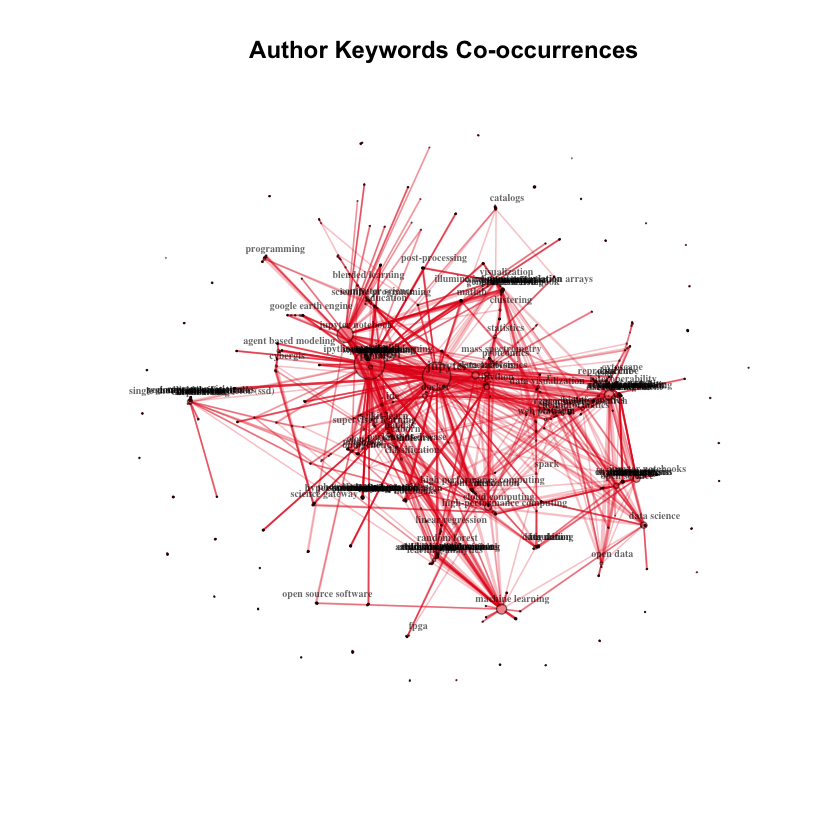

In [19]:
NetMatrix <- biblioNetwork(M, analysis = "co-occurrences", network = "author_keywords", sep = ";")
net <- networkPlot(NetMatrix, Title="Author Keywords Co-occurrences",
                   normalize="association", type="auto", cluster="none", degree=NULL, weighted=TRUE,                #methods
                   noloops=TRUE, remove.multiple=FALSE, remove.isolates = TRUE, alpha=0.5, halo=TRUE,                   #other options
                   label=TRUE, labelsize=1, label.cex=TRUE, label.color=FALSE, label.n = 150,                            #labels
                   n = 4000, size=10, size.cex=TRUE,                                                                   #vertes/nodes 
                   edgesize=10, edges.min=1, curved = 0)                                                              #edges
net2VOSviewer(net, vos.path="Temporal Outputs/Co-occurrences")

### **Co-Citation of Authors**

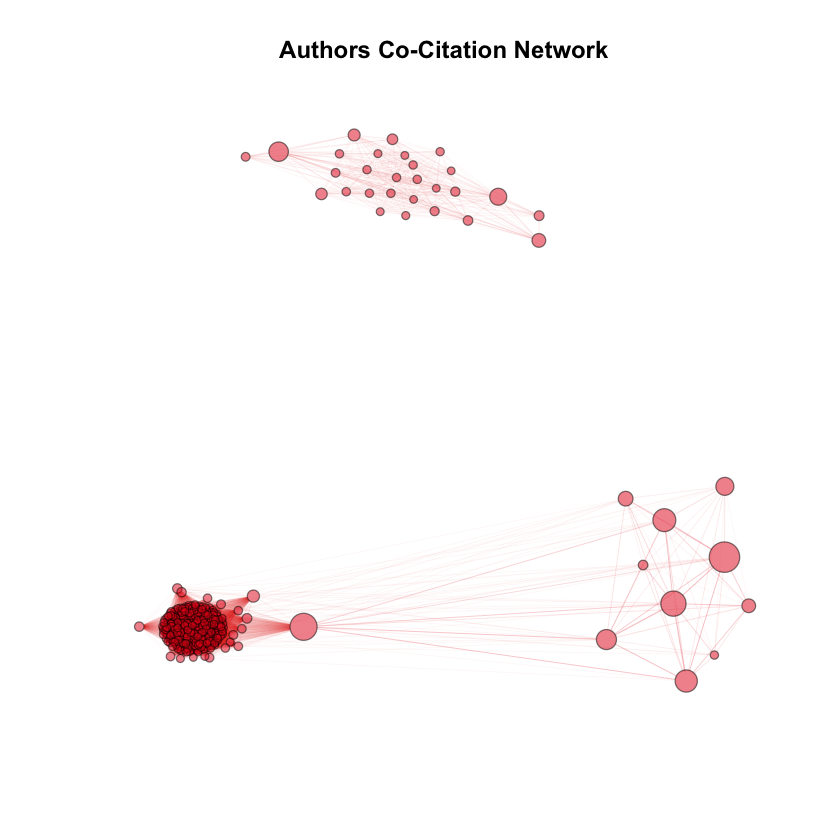

In [20]:
NetMatrix <- biblioNetwork(M, analysis = "co-citation", network = "authors", sep = ";")
net <- networkPlot( NetMatrix, Title="Authors Co-Citation Network",
                   normalize="association", type="auto", cluster="none", degree=NULL, weighted=TRUE,                #methods
                   noloops=TRUE, remove.multiple=TRUE, remove.isolates = TRUE, alpha=0.5, halo=TRUE,                   #other options
                   label=TRUE, labelsize=1, label.cex=FALSE, label.color=FALSE, label.n = 300,                            #labels
                   n=300, size=10, size.cex=TRUE,                                                                       #vertes/nodes 
                   edgesize=1, edges.min=0.5, curved = 0)
net2VOSviewer(net, vos.path="Temporal Outputs/Co-citations")

### **Bibliographic Coupling of Authors**

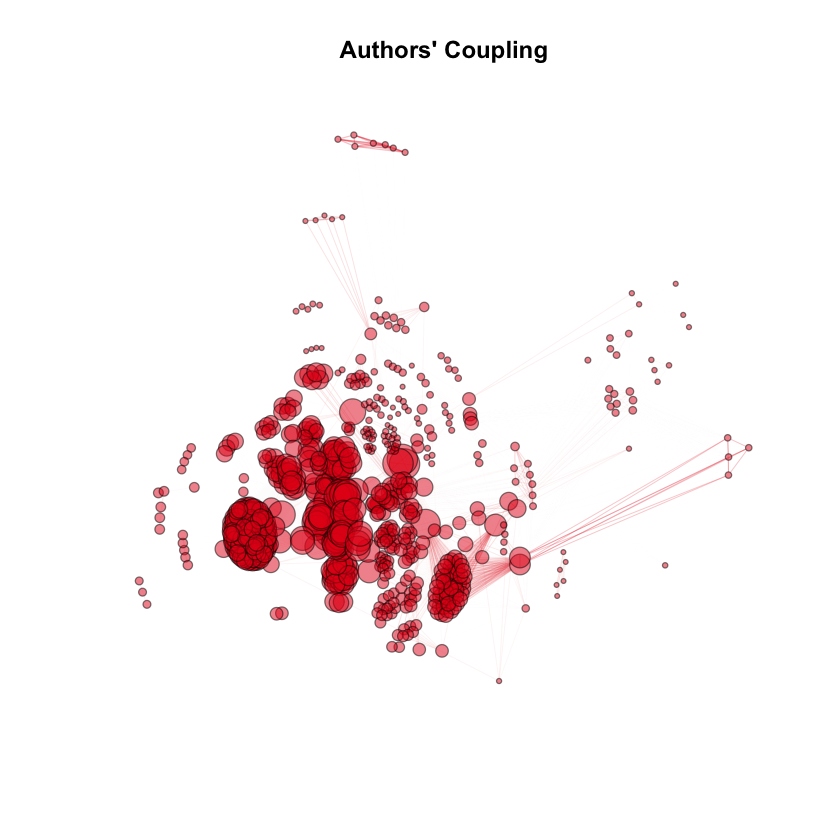

In [21]:
NetMatrix <- biblioNetwork(M, analysis = "coupling", network = "authors",sep = ";", shortlabel = FALSE)
net <- networkPlot( NetMatrix, Title="Authors' Coupling",
                   normalize="association", type="auto", cluster="none", degree=NULL, weighted=TRUE,                #methods
                   noloops=TRUE, remove.multiple=TRUE, remove.isolates = TRUE, alpha=0.5, halo=TRUE,                   #other options
                   label=TRUE, labelsize=1, label.cex=FALSE, label.color=FALSE, label.n = 800,                            #labels
                   n=800, size=10, size.cex=TRUE,                                                                       #vertes/nodes 
                   edgesize=1, edges.min=0.5, curved = 0)
net2VOSviewer(net, vos.path="Temporal Outputs/Bibliographic Coupling")

### **Collaboration of Countries**

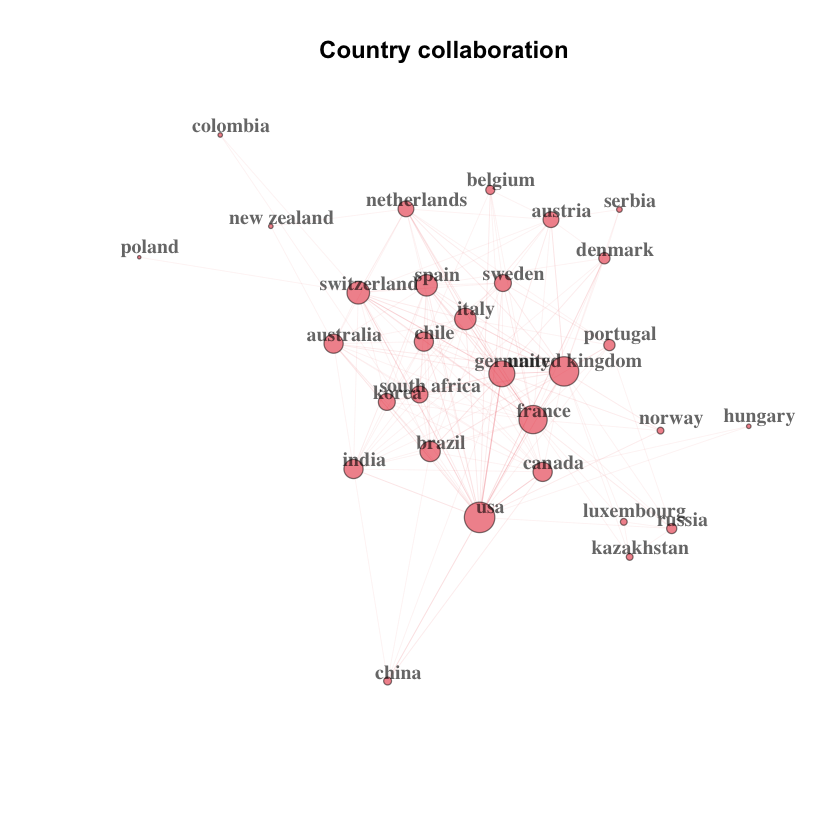

In [22]:
# This one uses AU_CO metatag
NetMatrix <- biblioNetwork(M, analysis = "collaboration",  network = "countries", sep = ";")
net <- networkPlot( NetMatrix, Title="Country collaboration",
                   normalize="association", type="auto", cluster="none", degree=NULL, weighted=TRUE,                #methods
                   noloops=TRUE, remove.multiple=TRUE, remove.isolates = TRUE, alpha=0.5, halo=TRUE,                   #other options
                   label=TRUE, labelsize=1, label.cex=FALSE, label.color=FALSE,                            #labels
                    n = 30, size=10, size.cex=TRUE,                                                   #vertes/nodes 
                   edgesize=1, edges.min=0.5, curved = 0)                                                              #edges
net2VOSviewer(net, vos.path="Temporal Outputs/Collaborations")

### **Networks Statistics**

**Here we print the available structural properties of the network, and a short summary (showing "k" rows)**

In [ ]:
netstat <- networkStat(NetMatrix, stat = "all", type = "authority")
names(netstat$network)
summary(netstat,k=100)
# Type: "degree", "closeness", "betweenness","eigenvector","pagerank","hub","authority"

## **Data Mining**

**Here we extract terms from textual fields of a manuscript (abstract, title, author’s keywords, keywords plus). Specifically, we start with Titles**

In [ ]:
scientometrics <- termExtraction(M, Field = "TI", stemming = FALSE,language = "english", remove.numbers = TRUE, 
               remove.terms = NULL,keep.terms = NULL, synonyms = NULL, verbose = TRUE)

**Now we see the terms extracted from the first 10 titles**

In [ ]:
scientometrics$TI_TM[1:10]

**Now we extract terms from abstracts and show the terms extracted from the first abstract**

In [ ]:
scientometrics <- termExtraction(M, Field = "AB", stemming = FALSE,language = "english", remove.numbers = TRUE, 
               remove.terms = NULL,keep.terms = NULL, synonyms = NULL, verbose = TRUE)

In [ ]:
scientometrics$AB_TM[1]

## **Co-Word Analysis: The conceptual structure of a field**  
<div style="text-align: justify"> Co-Word analysis uses the most important words or keywords of documents to study the conceptual structure of a research field (It is the only method that uses the actual content of the documents to construct a similarity measure).  
It produces semantic maps of a field. Conceptual structure is often used to understand the topics covered by scholars (so-called research front) and identify what are the most important and the most recent issue.
Here we map the conceptual structure by using the word co-occurrences in a bibliographic collection. It performs Correspondence Analysis (CA) or Multiple Correspondence Analysis (MCA) to draw a conceptual structure of the field and K-means clustering to identify clusters of documents which express common concepts. </div>  
Outputs include:  

- Conceptual Structure Map
- Topic Dendogram
- Factorial maps of the documents with the highest contributes and 
- factorial map of the most cited documents

**Conceptual Structure Function**  

| Function Parameter |   Possibilities   |    Definition    |
|:--------------------:|:-------------------:|:------------------:|
|*1- Methods*|
|   **Field**    | "ID", "DE", "ID_TM", "DE_TM", "TI" or "AB"| Terms extracted from Keywords plus, author's keywords, keywords plus stemmed through Porter's algorithm, Author keywords stemmed through Porter's algorithm, terms extracted from titles and terms extracted from abstracts respectively|
|     **method**       | "CA", "MCA" or "MDS"       | Indicates the factorial method used to create the factorial map: Correspondence Analysis, Multiple CA or Metric Multidimensional Scaling (default is MCA)|
|     **clust**          | "auto" or integer (2-8)     |Indicates the number of clusters to map |
|     **k.max**          | *integer* (max 20) | Indicates maximum number of cluster to keep (default is 5)|
|     **steeming**          | "TRUE" or "FALSE"         | If TRUE, Porter's Stemming algorithm is applied to all extracted terms (default is false)|
|     **mindegree**          |  *integer*      |indicates the minimum occurrences of terms to analize and plot (default is 2)|
|     **labelsize**          | *integer*   | Indicates the label size in the plot (default is 10)|
|     **graph**          |  "TRUE" or "FALSE"        | If TRUE the function plots the maps otherwise they are saved in the output object (Default is true)|
|     **documents**          | *integer*      |Indicates the number of documents to plot in the factorial map, used for CA and MCA (default is 10).|
|*2- only for CA and MCA*|
|     **quali.supp**    | vector    |Vector indicating the indexes of the categorical supplementary variables, used only for CA and MCA |
|     **quanti.supp**          | vector   | Vector indicating the indexes of the quantitative supplementary variables, used only for CA and MCA |

In [ ]:
# Using CA method over Keywords Plus
CS <- conceptualStructure(M, field="DE", method="MCA", clust="3", k.max = 10, stemming=FALSE, minDegree=10, labelsize=10, documents=20)

## **Thematic Evolution Analysis**  

Co-word analysis draws clusters of keywords. They are considered as themes, whose density and centrality can be used in classifying themes and mapping in a two-dimensional diagram. Thematic map is a very intuitive plot and we can analyze themes according to the quadrant in which they are placed: (1) upper-right quadrant: motor-themes; (2) lower-right quadrant: basic themes; (3) lower-left quadrant: emerging or disappearing themes; (4) upper-left quadrant: very specialized/niche themes.  
The Thematic Map funciton creates a thematic map based on co-word network analysis and clustering. The methodology is inspired by the proposal of Cobo et al. (2011).

**First we generate Thematic Maps**

In [ ]:
res <- thematicMap(M, field = "DE", n = 2000, minfreq = 3, stemming = FALSE, size = 0.4, n.labels=3, repel = TRUE)
plot(res$map)

**Second we produce a Thematic Evolution Analysis**

In [ ]:
years = c(2005,2018)
nexus <- thematicEvolution(M, field = "DE", years=years, n = 10, minFreq = 7, size = 0.5, stemming = FALSE, n.labels = 1, repel = TRUE)
plot(nexus$map)

**From the Thematic Maps we can finally produce the Thematic Evolution Analysis**

In [ ]:
TE <- plotThematicEvolution(nexus$Nodes, nexus$Edges, measure = "inclusion", min.flow = 0.5)

## **Reference Publication Year Spectroscopy**  
rpys computes a Reference Publication Year Spectroscopy for detecting the Historical Roots of Research Fields. The method was introduced by Marx et al., 2014.

In [ ]:
years = c(2000,2018)
res <- rpys(M, sep = ";", timespan = years, graph = T)

## **Historical Direct Citation Network**  
The historiographic map (proposed by E. Garfield) represents a chronological networkmap of most relevant direct citations resulting from a bibliographic collection. We first create the historical citation network, and then we plot it.

In [ ]:
histResults <- histNetwork(M, min.citations = 10, sep = ";", verbose=FALSE)
net <- histPlot(histResults, n=50, size = 5, labelsize=7, verbose=FALSE)